# One-shot multi-step LSTM Model on Syn b698
Author: Camilla Billari <br> 
Date: 06/02/24

Fitting a one-shot multi-step LSTM to the synthetic b698 dataset.

In [1]:
# Import relevant libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import local_paths

# Change local path
sys.path.append(local_paths.MAIN_DIRECTORY)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
import scripts.general_functions as gfn
import scripts.lstm_oneshot_multistep as lstm

In [2]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load Data

In [3]:
EXP = "b698" # select Marone p4679 experiment

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,11.225116,17.382861,20.088637,22.167371,0.00
1,11.222870,17.375571,20.088683,22.167447,0.01
2,11.224972,17.385328,20.088975,22.167941,0.02
3,11.221124,17.373017,20.088549,22.167221,0.03
4,11.225461,17.386512,20.089116,22.168180,0.04


In [4]:
# Select segment average and scale down by 10^8
shear_stress_df = df["obs_shear_stress"]

shear_stress_df.shape

(20001,)

## Data Pre-processing

### Denoising

In [5]:
# Data smoothing
SMOOTHING_WINDOW = 1 # moving average window size
DOWNSAMPLING_FACTOR = 5

# Smooth the data
df_smoothed = gfn.moving_average_causal_filter(shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_smoothed.shape

(4000,)

In [6]:
# Check if smoothed results are statistically significantly different
results = gfn.compare_feature_statistics(shear_stress_df, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': 0.0019471267627161036, 'p_value': 0.9984464347835562, 'significant': False}, 'variance_comparison': {'f_statistic': 3.791302626803175e-06, 'p_value': 0.9984464348098129, 'significant': False}}


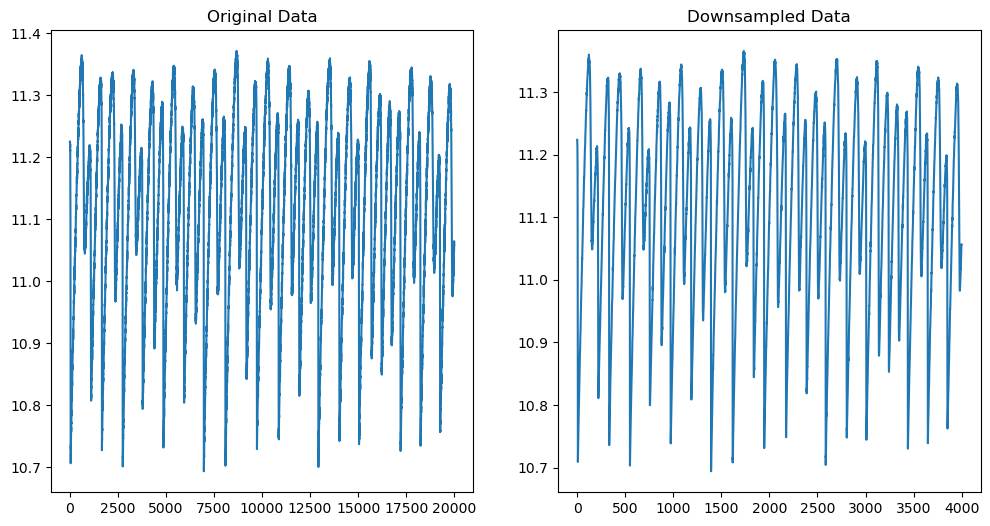

In [7]:
gfn.plot_original_vs_processed_data(shear_stress_df, df_smoothed, "line", "Downsampled")

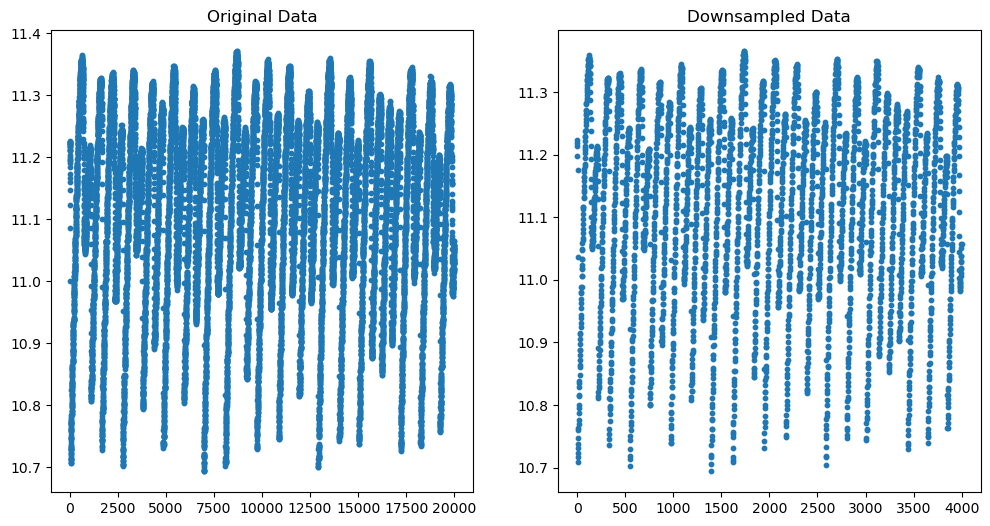

In [8]:
gfn.plot_original_vs_processed_data(shear_stress_df, df_smoothed, "scatter", "Downsampled")

## Creating the datastet

In [9]:
# Dataset parameters
LOOKBACK, FORECAST = 80, 14 # lookback and forecast values
N_FORECAST_WINDOWS = 40 # n forecasted windows in test set

# Pre-process the data into windows
X, y = gfn.create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3907, 80]), torch.Size([3907, 14])


In [10]:
# Split into train and test sets and normalise it
X_train, y_train, X_test, y_test = gfn.split_train_test_forecast_windows(X, y, FORECAST, N_FORECAST_WINDOWS)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([3346, 80]), torch.Size([3346, 14])
Testing data shapes: torch.Size([560, 80]), torch.Size([560, 14])


### Normalising with scaler based on the training set

In [11]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = gfn.normalise_dataset(X_train, y_train, X_test, y_test)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])


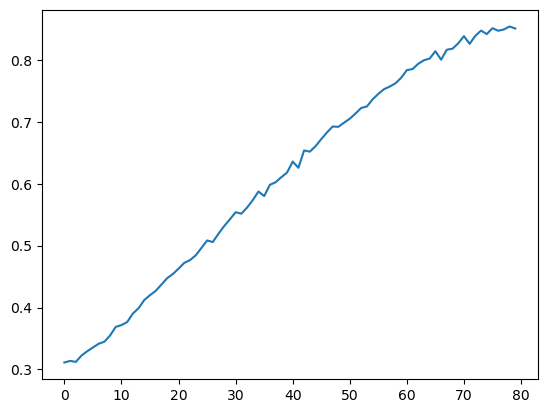

In [12]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

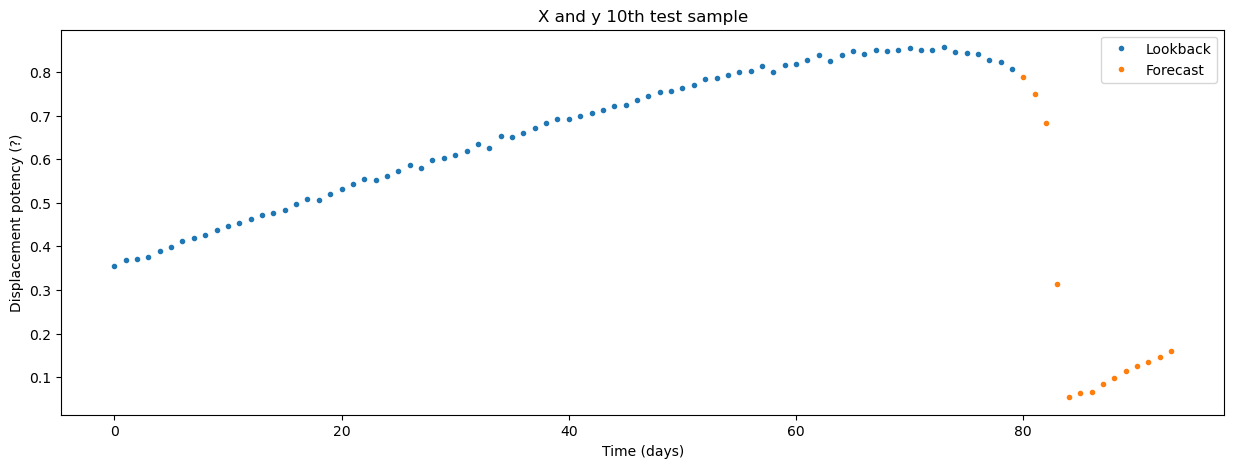

In [13]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(LOOKBACK, LOOKBACK + FORECAST), data_dict["y_test_sc"][10], ".", label="Forecast")
plt.title("X and y 10th test sample")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

## Modelling

In [14]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLstmSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

### Training

In [15]:
# For LSTM training
N_EPOCHS = 75
results_dict = lstm.train_lstm(model, N_EPOCHS, data_dict, scaler_y, device)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0453, Test RMSE: 0.0592, Train R2: 0.9125, Test R2: 0.8551, Last Batch Loss: 0.0012: 100%|██████████| 75/75 [06:21<00:00,  5.09s/it]


## Results

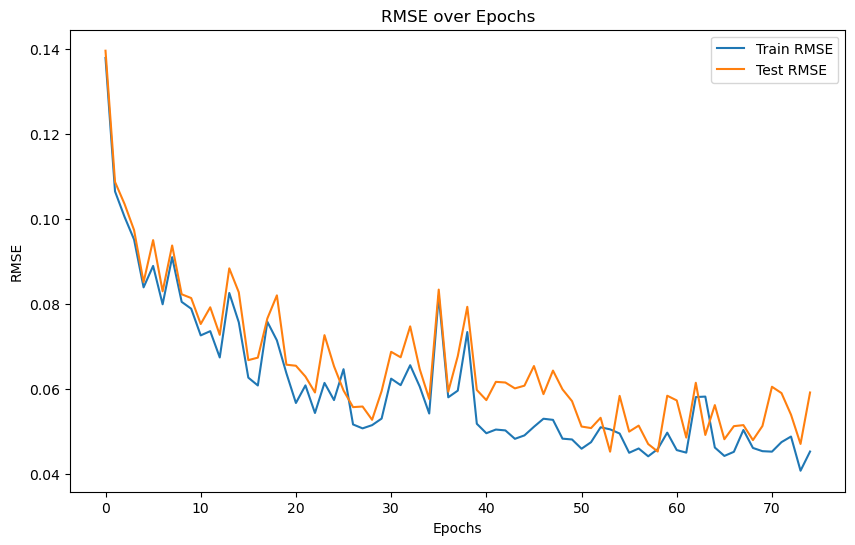

In [17]:
# Plot RMSE
gfn.plot_metric_results(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

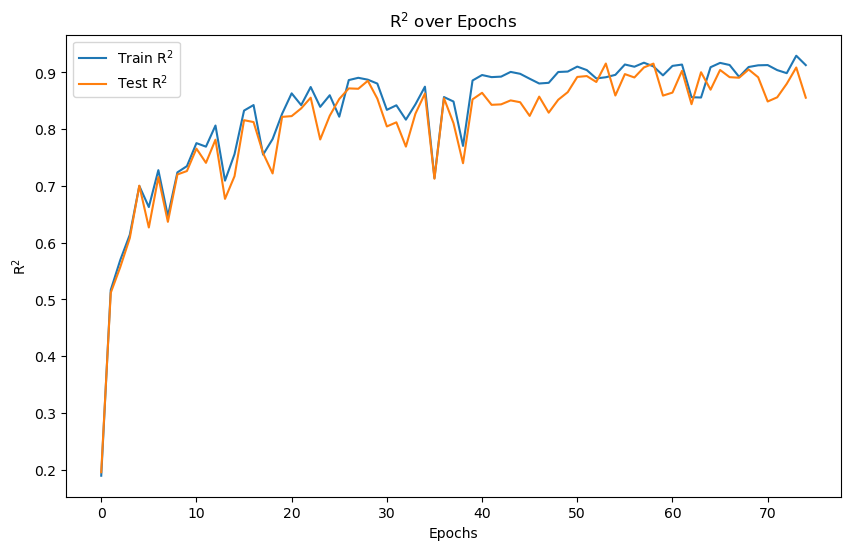

In [18]:
# Plot R2
gfn.plot_metric_results(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [19]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 3600
ZOOM_MAX = 3800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

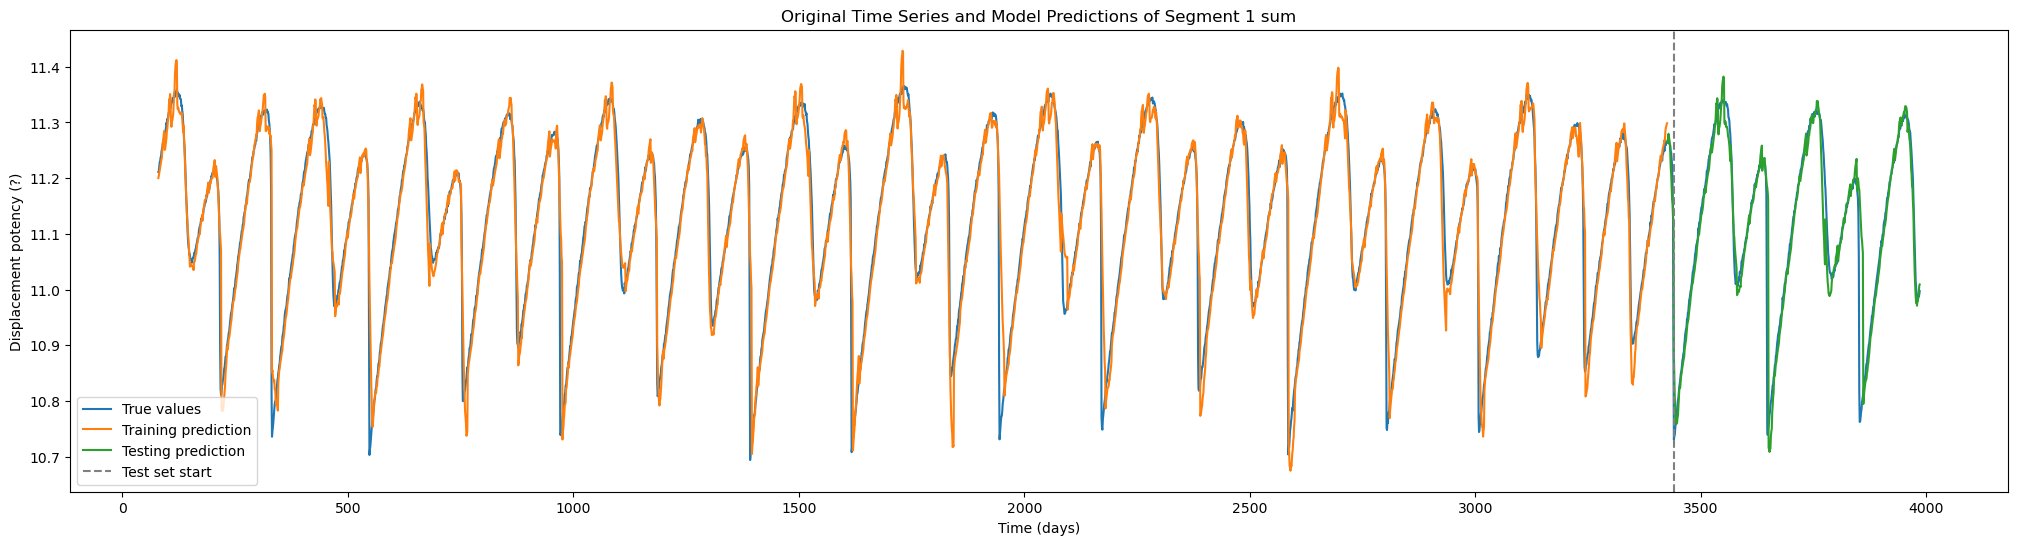

In [20]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


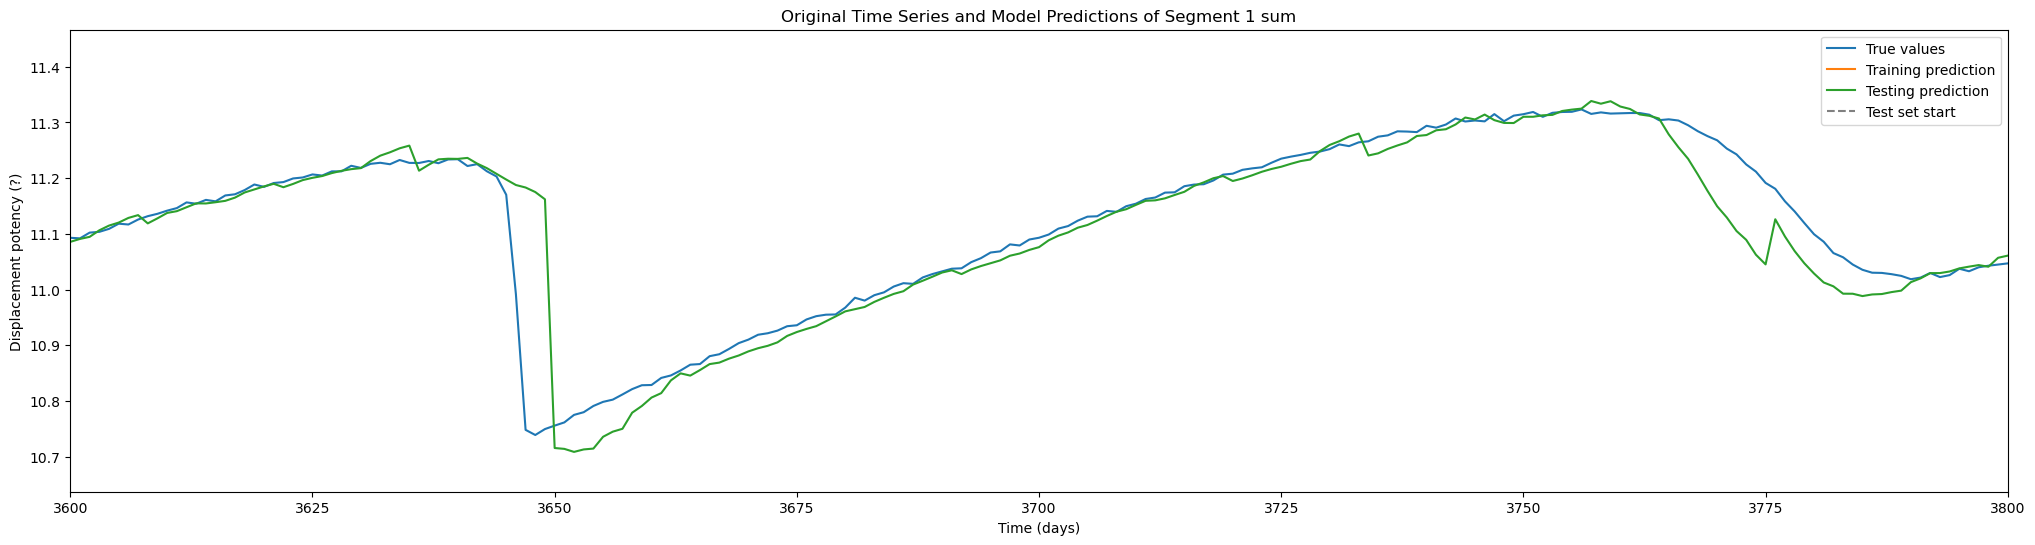

In [21]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)
# LOOK AT BOKE

## Pritt's LSTM

In [14]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST
model_multi_layer = lstm.MultiStepLstmMultiLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

In [15]:
# For LSTM training
N_EPOCHS = 75
results_dict_multi_layer = lstm.train_lstm(model_multi_layer, N_EPOCHS, data_dict, scaler_y, device)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0395, Test RMSE: 0.0516, Train R2: 0.9335, Test R2: 0.8899, Last Batch Loss: 0.0012: 100%|██████████| 75/75 [07:43<00:00,  6.17s/it]


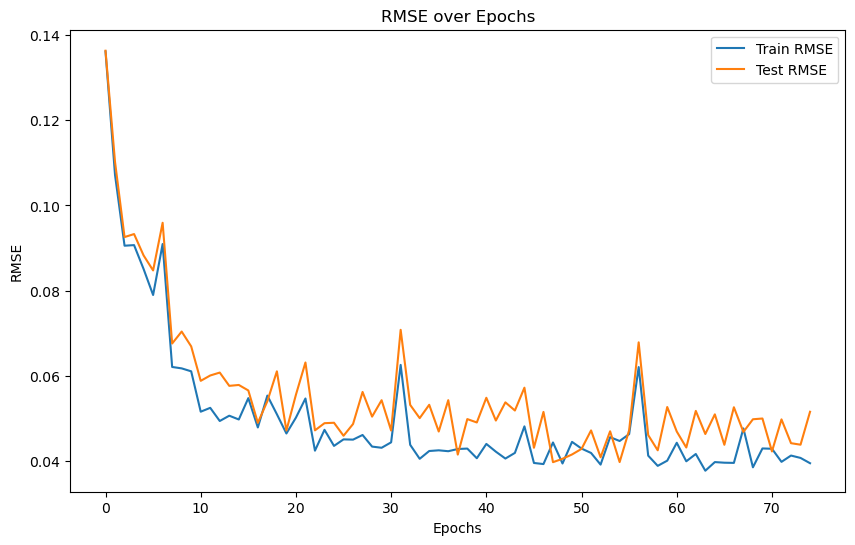

In [16]:
# Plot RMSE
gfn.plot_metric_results(N_EPOCHS, results_dict_multi_layer["train_rmse_list"], results_dict_multi_layer["test_rmse_list"], "RMSE")

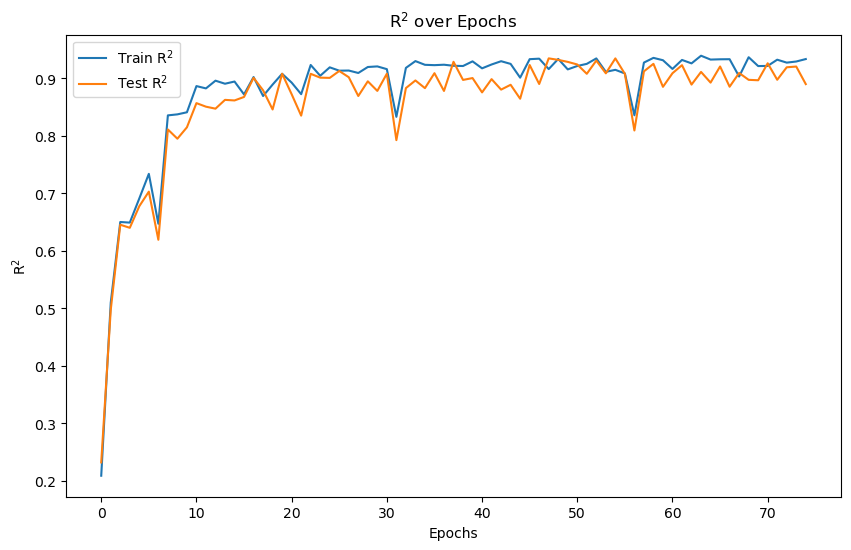

In [17]:
# Plot R2
gfn.plot_metric_results(N_EPOCHS, results_dict_multi_layer["train_r2_list"], results_dict_multi_layer["test_r2_list"], "R$^2$")

In [18]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 3600
ZOOM_MAX = 3800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

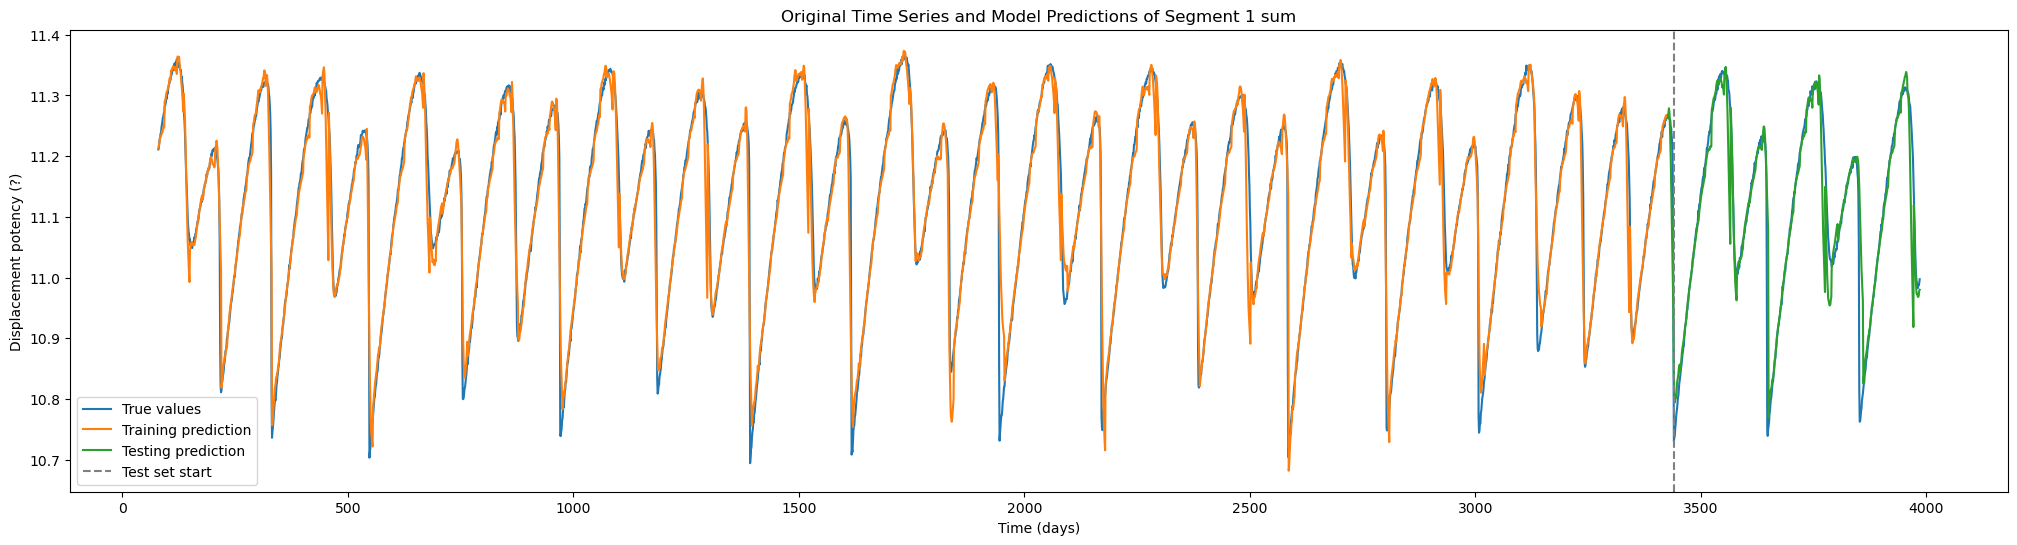

In [19]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])

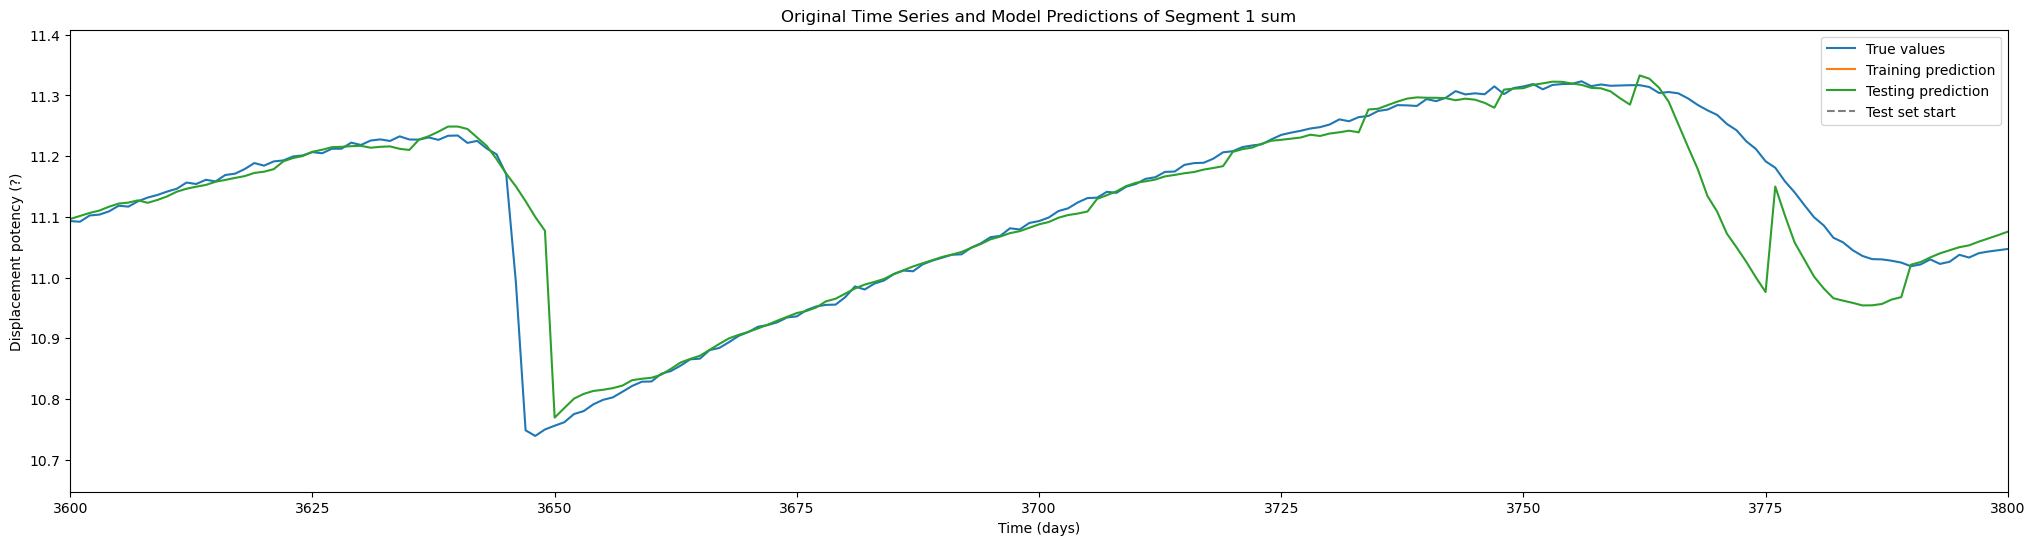

In [20]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)